## Exercise 3: Likelihood Calculations

### Exercise 3a

1. Instantiate a `N(0, 10)` distribution using `scipy`
2. Calculate the likelihood for each of the following values
    * 0
    * -1
    * 1
    * 100

Do the results returned make sense? Why or why not?

In [3]:
from scipy import stats
import polars as pl
from polars import col
import arviz as az
import pymc as pm

az.style.use("arviz-darkgrid")

In [4]:
normal = stats.norm(loc=0, scale=10)
values = [0, -1, 1, 100]

In [5]:
normal.pdf(values)

array([3.98942280e-02, 3.96952547e-02, 3.96952547e-02, 7.69459863e-24])

These results make sense to me as we'd expect the value with the highest density to be 0 given that the mean of the distribution is 0. Moreover, it makes sense that 1 and -1 have the same density as they are the same distance from 0. 100 having the lowest density also makes sense given that it's way outside two standard deviations of the `N(0, 10)` distribution.

### Exercise 3b

1. Using the A/B test data, calculate the likelihood value at the following conversion rates:
    * 5%
    * 10%
    * 50%

For this, you'll need to recall what likelihood function is most appropriate for this data. The observations file `b_observations.txt` can be found in the data folder in the Distributions lesson.

## Exercise 4: Estimating conversion rates yourself

### Estimating Website A

Use the full Bayesian modeling workflow to estimate the conversion rate. Generate a posterior plot and calculate the 94% HDI using ArviZ.

In [7]:
website_a = pl.read_csv("data/website_a.csv")
website_a

,website_a
i64,i64
0,1
1,0
2,1
3,1
4,0
5,0
6,1
7,1
8,1


In [8]:
with pm.Model() as website_a_model:
    conversion_rate = pm.Beta("conversion_rate", alpha=15, beta=12)
    
    n_signups = pm.Binomial(
        "n_signups",
        p=conversion_rate,
        n=len(website_a["website_a"]),
        observed=website_a["website_a"].sum()
    )

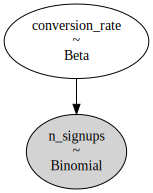

In [9]:
pm.model_to_graphviz(website_a_model)

In [10]:
with website_a_model:
    website_a_idata = pm.sample(draws=1000, tune=1000)
    website_a_idata.extend(pm.sample_prior_predictive(samples=1000))
    website_a_idata.extend(pm.sample_posterior_predictive(website_a_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

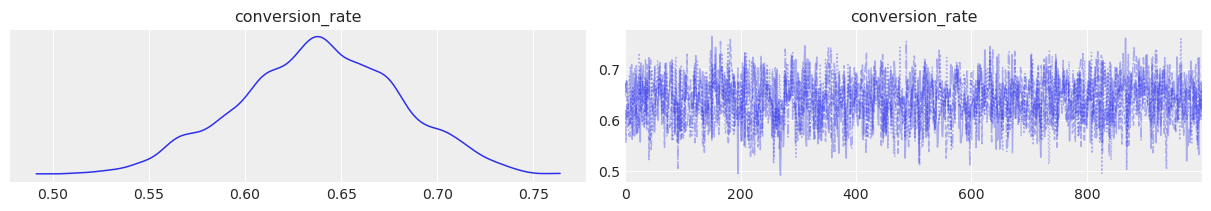

In [11]:
az.plot_trace(website_a_idata, var_names=["conversion_rate"], combined=True)

In [12]:
az.summary(website_a_idata, var_names=["conversion_rate"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
conversion_rate,0.638,0.043,0.559,0.718,0.001,0.001,1676.0,2887.0,1.0


array([<AxesSubplot:title={'center':'conversion_rate\n0'}>,
       <AxesSubplot:title={'center':'conversion_rate\n1'}>,
       <AxesSubplot:title={'center':'conversion_rate\n2'}>,
       <AxesSubplot:title={'center':'conversion_rate\n3'}>], dtype=object)

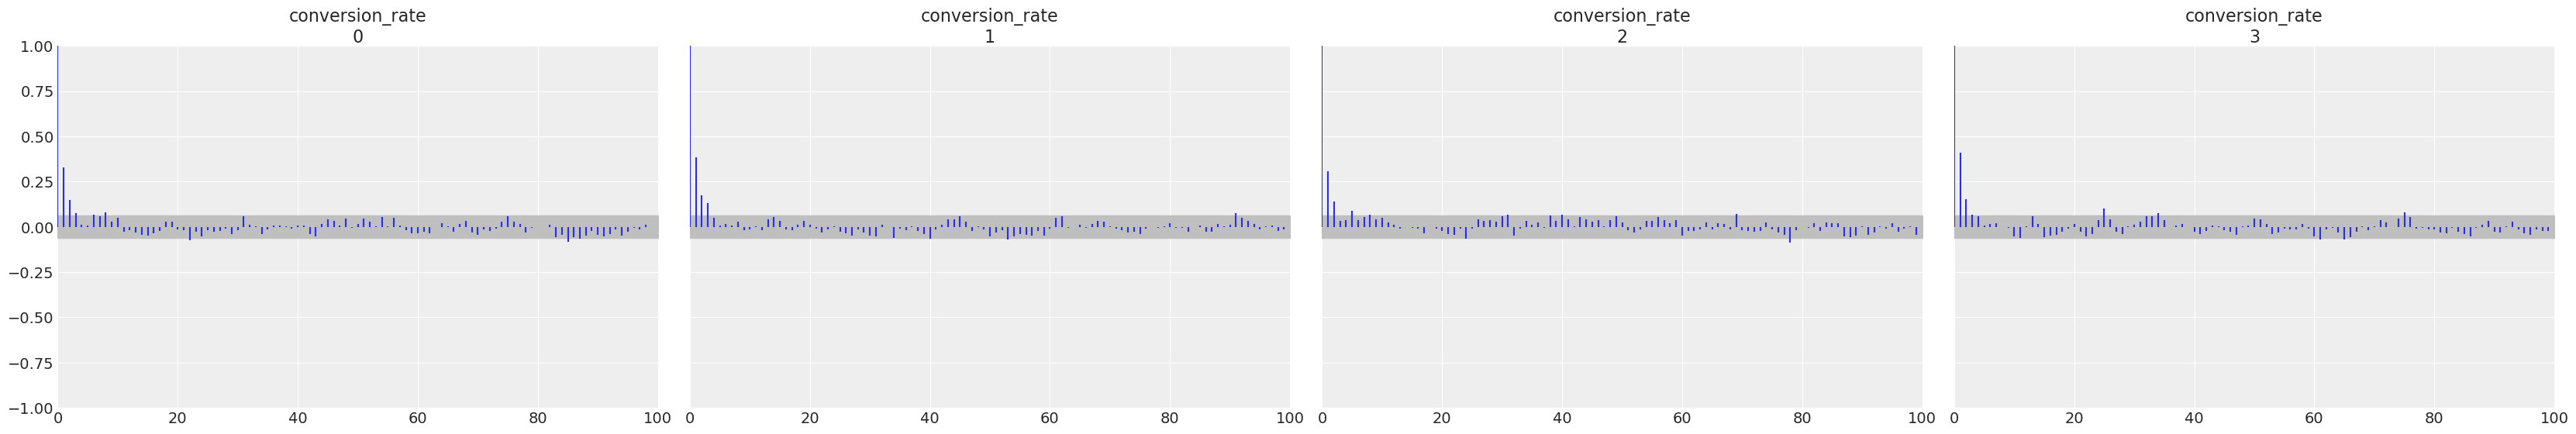

In [38]:
az.plot_autocorr(website_a_idata, var_names=["conversion_rate"])

<AxesSubplot:title={'center':'conversion_rate'}>

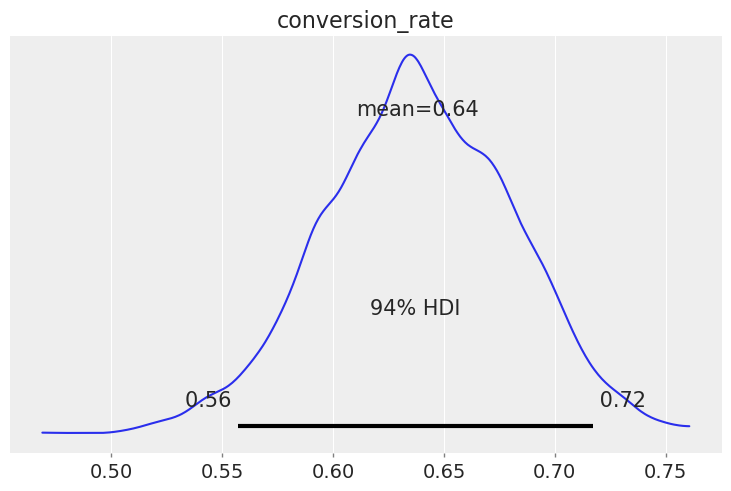

In [39]:
az.plot_posterior(website_a_idata, var_names=["conversion_rate"])

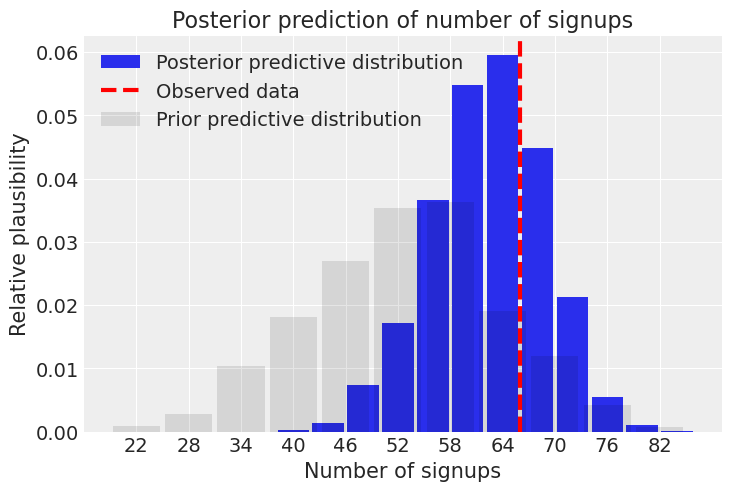

In [42]:
ax = az.plot_dist(
    website_a_idata.posterior_predictive["n_signups"],
    label="Posterior predictive distribution",
)

ax.axvline(
    website_a_idata.observed_data["n_signups"],
    color="red",
    ls="--",
    linewidth=3,
    label="Observed data",
)

az.plot_dist(
    website_a_idata.prior_predictive["n_signups"],
    label="Prior predictive distribution",
    hist_kwargs={"alpha": 0.1},
    color="black",
    ax=ax
)

ax.set(
    xlabel="Number of signups",
    ylabel="Relative plausibility",
    title="Posterior prediction of number of signups"
)
ax.legend()

### Estimating Website B

Do the same for Website B, but compare it to Website A. Is the estimated conversion rate different? How sure are we of this conversion rate (i.e. more than Website A, or less)? Why might this be the case?

In [15]:
website_b = pl.read_csv("data/website_b.csv")
website_b

,website_b
i64,i64
0,1
1,0
2,1
3,1
4,0
5,0
6,1
7,1
8,1


In [16]:
with pm.Model() as website_b_model:
    conversion_rate = pm.Beta("conversion_rate", alpha=15, beta=12)
    
    n_signups = pm.Binomial(
        name="n_signups",
        n=len(website_b["website_b"]),
        p=conversion_rate,
        observed=website_b["website_b"].sum()
    )

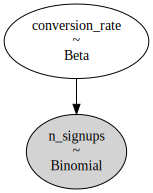

In [17]:
pm.model_to_graphviz(website_b_model)

In [18]:
with website_b_model:
    website_b_idata = pm.sample(draws=1000, tune=1000)
    website_b_idata.extend(pm.sample_prior_predictive(samples=1000))
    website_b_idata.extend(pm.sample_posterior_predictive(website_b_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

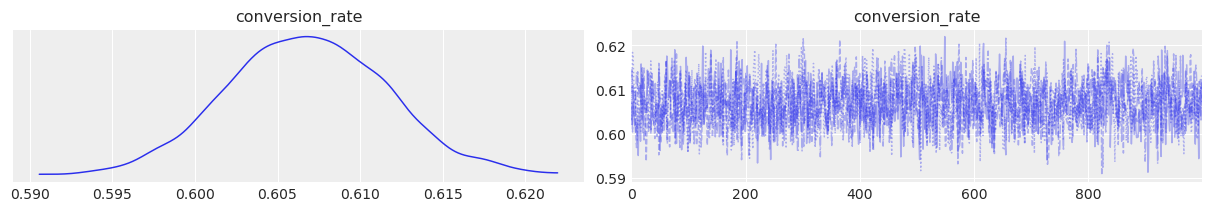

In [19]:
az.plot_trace(website_b_idata, var_names=["conversion_rate"], combined=True)

array([<AxesSubplot:title={'center':'conversion_rate\n0'}>,
       <AxesSubplot:title={'center':'conversion_rate\n1'}>,
       <AxesSubplot:title={'center':'conversion_rate\n2'}>,
       <AxesSubplot:title={'center':'conversion_rate\n3'}>], dtype=object)

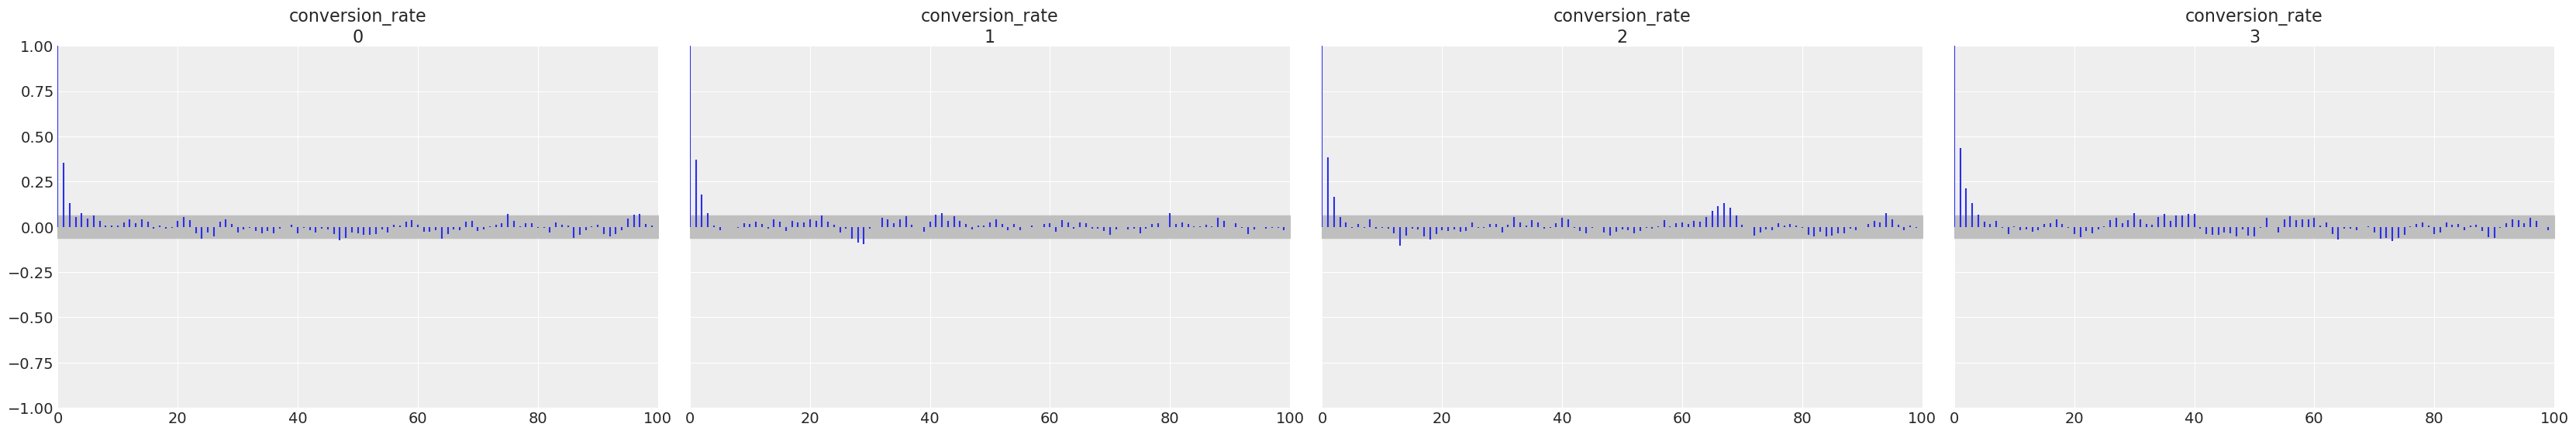

In [20]:
az.plot_autocorr(website_b_idata, var_names=["conversion_rate"])

<AxesSubplot:title={'center':'conversion_rate'}>

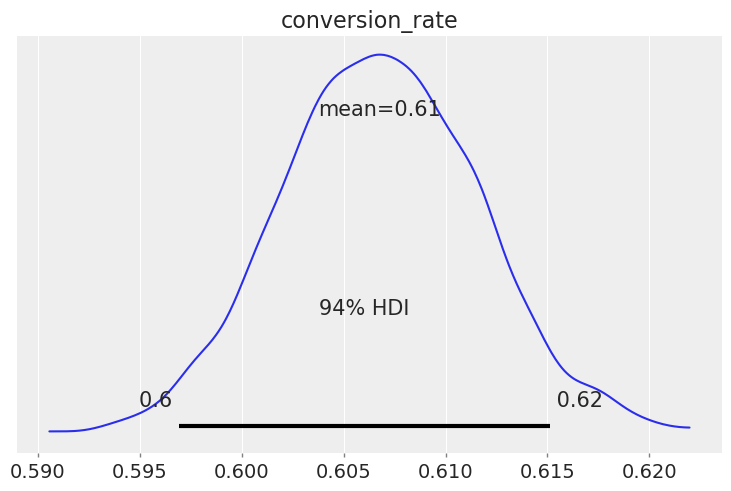

In [21]:
az.plot_posterior(website_b_idata, var_names=["conversion_rate"])

<AxesSubplot:>

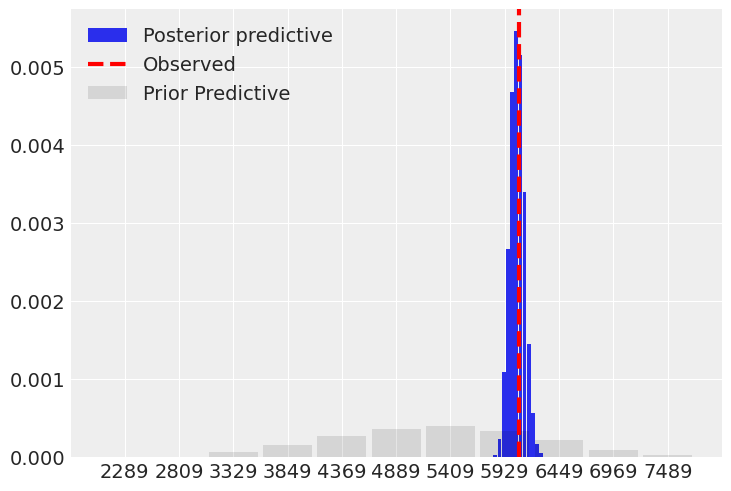

In [22]:
ax = az.plot_dist(
    website_b_idata.posterior_predictive["n_signups"],
    label="Posterior predictive"
)

ax.axvline(
    website_b_idata.observed_data["n_signups"],
    ls="--",
    linewidth=3,
    color="red",
    label="Observed"
)

az.plot_dist(
    website_b_idata.prior_predictive["n_signups"],
    label="Prior Predictive",
    hist_kwargs={"alpha": 0.1},
    color="black",
    ax=ax
)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

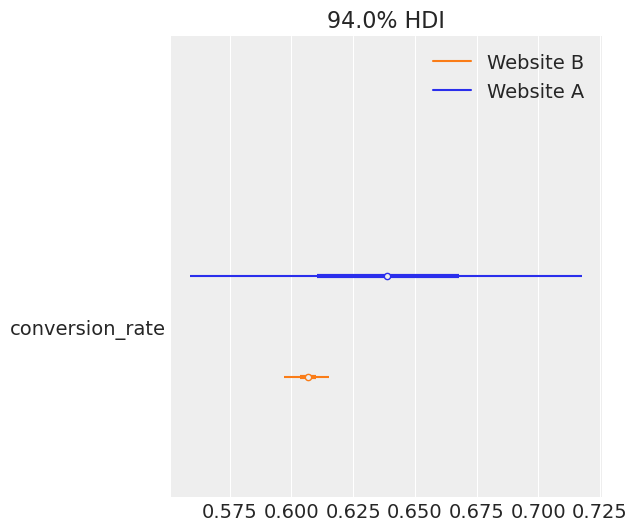

In [25]:
az.plot_forest(
    data=[website_a_idata, website_b_idata],
    kind="forestplot",
    model_names=["Website A", "Website B"],
    var_names=["conversion_rate"],
    combined=True
)

Looking at the 94% credible intervals for Website B and Website A, it's pretty easy to see that we are more certain about the conversion rate for Website B then Website A. We're more certain of this as the data for Website A only had 100 observations, while the data for Website A had 10,000 observations.

### Estimating Website C

Your boss now asks you to compare Website C with B. Your boss wants to know:

* What is the conversion rate of Website C?
* Should the company deploy Website C? Why or why not?

In [26]:
website_c = pl.read_csv("data/website_c.csv")
website_c

,website_c
i64,i64
0,0
1,0
2,0
3,0
4,1
5,1
6,0
7,0
8,0


In [27]:
with pm.Model() as website_c_model:
    conversion_rate = pm.Beta("conversion_rate", alpha=15, beta=12)
    
    n_signups = pm.Binomial(
        name="n_signups",
        n=len(website_c["website_c"]),
        p=conversion_rate,
        observed=website_c["website_c"].sum()
    )

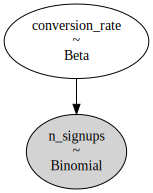

In [28]:
pm.model_to_graphviz(website_c_model)

In [29]:
with website_c_model:
    website_c_idata = pm.sample(draws=1000, tune=1000)
    website_c_idata.extend(pm.sample_prior_predictive(samples=1000))
    website_c_idata.extend(pm.sample_posterior_predictive(website_c_idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


array([[<AxesSubplot:title={'center':'conversion_rate'}>,
        <AxesSubplot:title={'center':'conversion_rate'}>]], dtype=object)

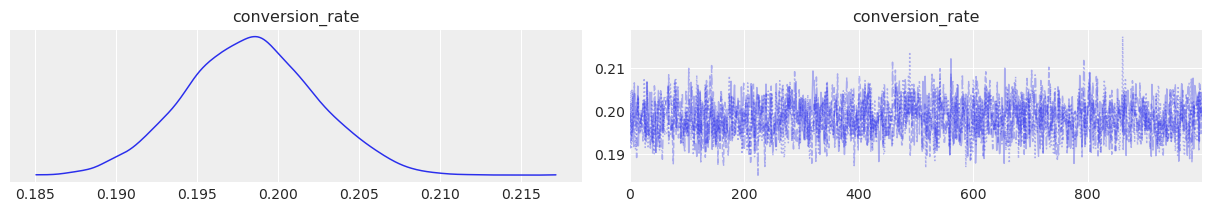

In [30]:
az.plot_trace(website_c_idata, var_names=["conversion_rate"], combined=True)

array([<AxesSubplot:title={'center':'conversion_rate\n0'}>,
       <AxesSubplot:title={'center':'conversion_rate\n1'}>,
       <AxesSubplot:title={'center':'conversion_rate\n2'}>,
       <AxesSubplot:title={'center':'conversion_rate\n3'}>], dtype=object)

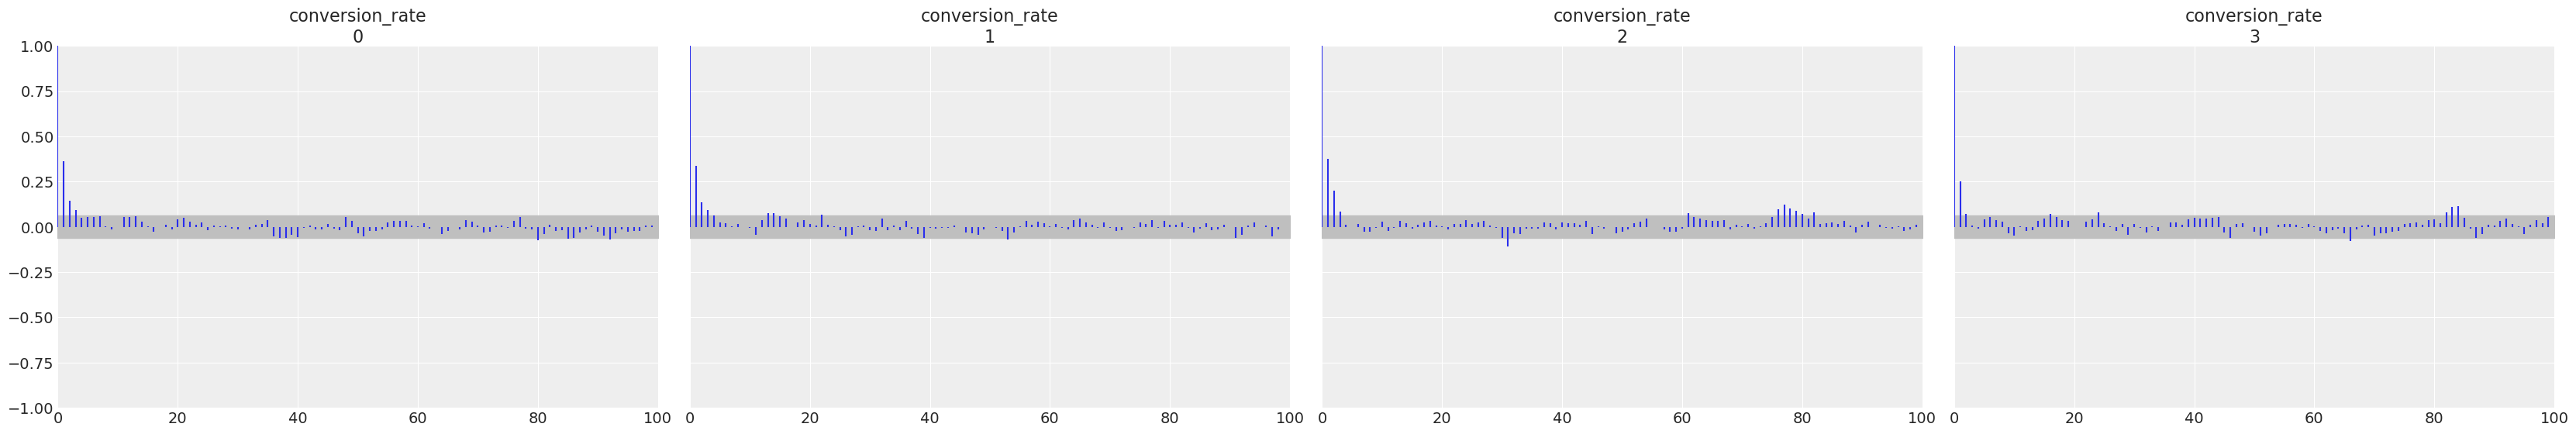

In [31]:
az.plot_autocorr(website_c_idata, var_names=["conversion_rate"])

<AxesSubplot:title={'center':'conversion_rate'}>

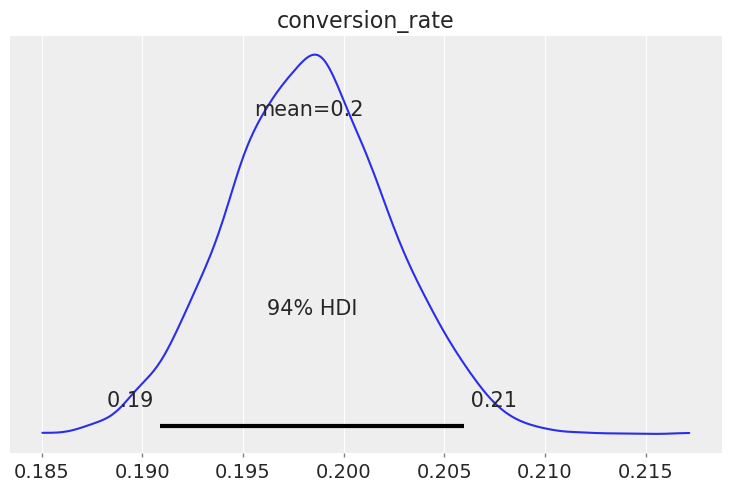

In [32]:
az.plot_posterior(website_c_idata, var_names=["conversion_rate"])

<AxesSubplot:>

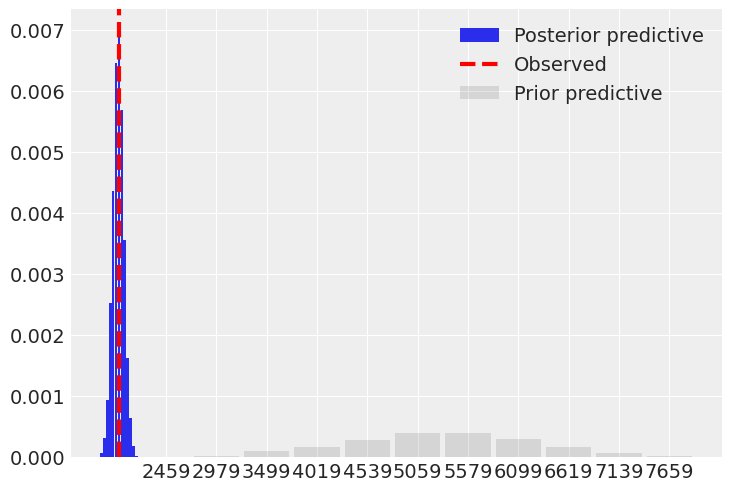

In [33]:
ax = az.plot_dist(
    website_c_idata.posterior_predictive["n_signups"],
    label="Posterior predictive"
)

ax.axvline(
    website_c_idata.observed_data["n_signups"],
    color="red",
    ls="--",
    linewidth=3,
    label="Observed"
)

az.plot_dist(
    website_c_idata.prior_predictive["n_signups"],
    color="black",
    hist_kwargs={"alpha": 0.1},
    label="Prior predictive",
    ax=ax    
)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

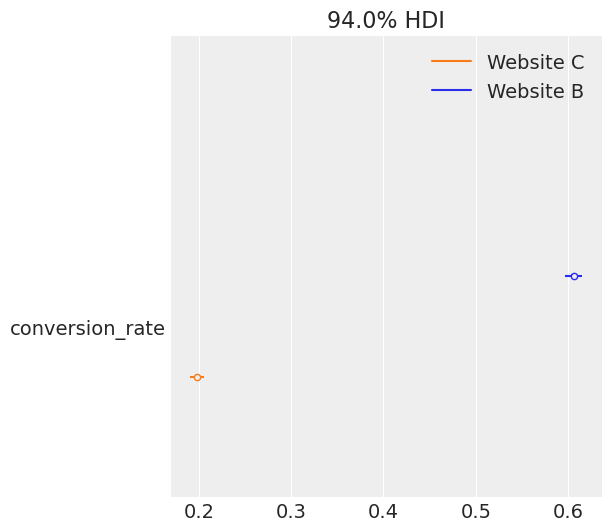

In [34]:
az.plot_forest(
    data=[website_b_idata, website_c_idata],
    kind="forestplot",
    model_names=["Website B", "Website C"],
    var_names=["conversion_rate"],
    combined=True
)

Based on the forest plot, it's pretty obvious that we should not deploy Website C as the conversion rate is around 20%, while the conversion rate for Website B is slightly over 60%.